# Data Extraction

In [1]:
import io
import os
import re
import tarfile
from pathlib import Path

import chardet
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.parquet.enableVectorizedReader", "false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/19 22:00:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
APACHE_SPAM_ASSASSIN = "https://spamassassin.apache.org/old/publiccorpus"
DATA_FOLDER = '../data'

In [4]:
def pull_data():
    response = requests.get(APACHE_SPAM_ASSASSIN)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')
    file_paths = [link.get('href') for link in soup.find_all('a')]
    file_paths = [path for path in file_paths if path.split('.')[-1] == 'bz2']

    available_data = set(os.listdir(DATA_FOLDER))
    file_paths = [path for path in file_paths if path not in available_data and path != 'corpus.parquet']

    if len(file_paths) == 0:
        print('No data to pull')

    for file_path in file_paths:
        print(f'Pulling {file_path}')
        response = requests.get(f"{APACHE_SPAM_ASSASSIN}/{file_path}")
        response.raise_for_status()

        file_object = io.BytesIO(response.content)
        tar = tarfile.open(fileobj=file_object, mode="r:bz2")

        extract_dir = Path(DATA_FOLDER)
        extract_path = extract_dir.joinpath(Path(file_path))

        extract_dir.mkdir(exist_ok=True)
        tar.extractall(extract_path)

        tar.close()

    size = get_directory_size("../data")
    print(f"Data directory size: {size} bytes")


def get_directory_size(directory):
    total = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total += os.path.getsize(fp)

    return total

In [10]:
pull_data()

No data to pull
Data directory size: 121604826 bytes


In [28]:
def parse_data():
    successful_files = []
    failed_files = []
    corpus_df = pd.DataFrame(columns=['date', 'difficulty', 'category', 'collection', 'body'])
    for dirpath, dirnames, filenames in os.walk(DATA_FOLDER):
        print(dirpath)
        if re.match(r"^.*\.parquet$", dirpath) is None:
            for filename in filenames:
                corpus_path = os.path.join(dirpath, filename)
                corpus_df, successful_files, failed_files = incorporate(corpus_df, corpus_path, dirpath, successful_files,
                                                                        failed_files)
    return corpus_df, successful_files, failed_files


def incorporate(df, corpus_path, dirpath, successful_files, failed_files):
    rawdata = open(corpus_path, 'rb').read()
    result = chardet.detect(rawdata)
    encoding = result['encoding']

    with open(corpus_path, 'r', encoding=encoding) as f:
        [(date, *ids)] = re.findall(r'([\d]{8})_([a-z]*)_?([a-z]*)_?([\d]*)\.tar\.bz2.*',
                                    dirpath)
        [difficulty, category, collection] = parse_ids(ids)
        try:
            body = f.read()
            row = pd.DataFrame({'date': date,
                                'difficulty': difficulty,
                                'category': category,
                                'collection': collection,
                                'body': body}, index=[0, 1, 2, 3, 4])
            df = pd.concat([df, row], ignore_index=True)
            successful_files.append(corpus_path)
        except Exception as E:
            print(E)
            failed_files.append(corpus_path)
    return df, successful_files, failed_files


def parse_ids(ids):
    cls, difficulty, collection = np.nan, np.nan, np.nan
    match ids:
        case [cls_, '', '']:
            cls = cls_
        case [difficulty_, cls_, '']:
            difficulty = difficulty_
            cls = cls_
        case [difficulty_, cls_, collection_]:
            difficulty = difficulty_
            cls = cls_
            collection = collection_
        case _:
            pass

    return [difficulty, cls, collection]


def save_as_parquet(df):
    spark_df = spark.createDataFrame(df)
    spark_df.write.parquet(f'{DATA_FOLDER}/corpus.parquet', mode='overwrite')

In [29]:
force_reload = True

if 'corpus.parquet' in set(os.listdir(DATA_FOLDER)) and not force_reload:
    df = spark.read.parquet(f'{DATA_FOLDER}/corpus.parquet')
    corpus_df = df.toPandas()
else:
    corpus_df, successful_files, failed_files = parse_data()
    print(failed_files)
    save_as_parquet(corpus_df)

../data
../data/20030228_hard_ham.tar.bz2
../data/20030228_hard_ham.tar.bz2/hard_ham
../data/20021010_hard_ham.tar.bz2
../data/20021010_hard_ham.tar.bz2/hard_ham
../data/20030228_spam_2.tar.bz2
../data/20030228_spam_2.tar.bz2/spam_2
'cp949' codec can't decode byte 0xb7 in position 4589: illegal multibyte sequence
'charmap' codec can't decode byte 0x90 in position 2832: character maps to <undefined>
'charmap' codec can't decode byte 0x9e in position 3019: character maps to <undefined>
'big5' codec can't decode byte 0xf9 in position 2730: illegal multibyte sequence
../data/20030228_easy_ham_2.tar.bz2
../data/20030228_easy_ham_2.tar.bz2/easy_ham_2
'cp949' codec can't decode byte 0xb7 in position 3140: illegal multibyte sequence
../data/20030228_spam.tar.bz2
../data/20030228_spam.tar.bz2/spam
'gb2312' codec can't decode byte 0xeb in position 1587: illegal multibyte sequence
'cp949' codec can't decode byte 0xb7 in position 3073: illegal multibyte sequence
'cp949' codec can't decode byte 0xb

23/06/19 22:31:13 WARN TaskSetManager: Stage 6 contains a task of very large size (11938 KiB). The maximum recommended task size is 1000 KiB.
23/06/19 22:31:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/06/19 22:31:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/06/19 22:31:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/06/19 22:31:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/06/19 22:31:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
23/06/19 22:31:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054

In [31]:
corpus_df['category'].value_counts()

category
ham     34765
        13935
spam     4955
Name: count, dtype: int64

# Preprocessing

## Categorical or Binary Features

In [34]:
preproc_df = corpus_df.drop_duplicates(subset='body')
preproc_df['category'] = preproc_df['category'].replace('', np.nan)
preproc_df = preproc_df.dropna(subset='category')
preproc_df.describe()

/var/folders/_t/kjvh_2295rnbf4fvm71_rcfm0000gn/T/ipykernel_49829/2717592929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preproc_df['category'] = preproc_df['category'].replace('', np.nan)


,date,difficulty,category,collection,body
count,7760,6779,7760,1400,7760
unique,2,2,2,1,7760
top,20030228,easy,ham,2,Return-Path: <bounce-lghtml-2534368@sprocket.l...
freq,4647,6311,6779,1400,1


In [35]:
def extract_headers(row):
    row['has_headers'] = True
    try:
        [headers, body] = row['body'].split('\n\n', maxsplit=1)
        header_rows = headers.split('\n')
        current_key = None
        for h in header_rows:
            row, current_key = parse_header(row, h, current_key)
        row['body'] = body
    except Exception as e:
        row['header_error'] = e
        row['has_headers'] = False
    return row


def parse_header(row, h, current_key):
    match re.split(r"([\w\-]+)\:\s*", h):
        case ['', key, value]:
            row[key.lower()] = value
            current_key = key.lower()
        case [value]:
            if current_key:
                row[current_key] += value
        case _:
            pass
    return row, current_key

preproc_df = preproc_df.apply(extract_headers, axis=1)
preproc_df.describe()

,approved-by,body,bounce-to,bounces-to,category,cc,collection,comment,comments,complain-to,...,x-virus-checked,x-virus-scanned,x-viruschecked,x-vopfilter-ip,x-webmail-userid,x-wigglefluff,x-wss-id,x-x-sender,x-yahoo-profile,x-zippy
count,9,7760,4,1,7760,1656,1400,6,73,4,...,2,43,1,2,1,4,8,114,189,4
unique,4,4826,1,1,2,471,1,1,28,1,...,1,9,1,1,1,1,7,17,35,4
top,DoNotUse@WORLDWIDEWORDS.ORG,URL: http://www.askbjoernhansen.com/archives/2...,DivX-bounce@krieger.mailshell.com,ems+P8T5PED6GPLZ4A@bounces.amazon.com,ham,fork@spamassassin.taint.org,2,li 0x18080B5EBAEAEC17619A6B51DFF93585D986F633 ...,In-reply-to Rick Baartman <baartman@lin12.triu...,abuse@linkgift.com,...,Yes,by AMaViS new-20020517,Checked,198.6.50.33,jac1@student.cs.ucc.ie,fuddtastic,11BC091D161421-01-01,lgonze@localhost.localdomain,tim2ubh,NOT fucking!! Also not a PACKAGE of LOOSE-LEAF...
freq,4,8,4,1,6779,123,1400,6,6,4,...,2,24,1,2,1,4,2,32,56,1


In [49]:
reduced_preproc_df = preproc_df.dropna(thresh=800, axis=1)
reduced_preproc_df.describe()

,body,category,cc,collection,content-transfer-encoding,content-type,date,delivered-to,difficulty,errors-to,...,subject,to,x-beenthere,x-mailer,x-mailman-version,x-mimeole,x-msmail-priority,x-priority,x-spam-level,x-spam-status
count,7760,7760,1656,1400,3242,6833,7760,7210,6779,4482,...,3591,7535,4442,2796,4443,828,858,1103,2155,2155
unique,4826,2,471,1,8,370,2,58,2,48,...,1854,1156,32,226,9,18,4,7,11,1785
top,URL: http://www.askbjoernhansen.com/archives/2...,ham,fork@spamassassin.taint.org,2,7bit,text/plain; encoding=utf-8,20030228,yyyy@localhost.netnoteinc.com,easy,fork-admin@xent.com,...,[Spambayes] Deployment,yyyy@example.com,fork@spamassassin.taint.org,Microsoft Outlook Express 6.00.2600.0000,2.0.11,Produced By Microsoft MimeOLE V6.00.2600.0000,Normal,3 (Normal),,"No, hits=0.0 required=5.0\ttests=AWL\tversion=..."
freq,8,6779,123,1400,2200,1262,4647,1249,6311,1760,...,21,622,1060,180,2416,337,840,556,2117,158


In [50]:
def extract_email_address(row, cols):
    for col in cols:
        if str(row[col]) and type(row[col]) != list:
            row[col] = re.findall(r"([^\s\<]+\@[^\s\>]+)", str(row[col])) or None
    return row

In [51]:
envelope_cols = ['delivered-to', 'errors-to', 'from', 'in-reply-to', 'list-id', 'message-id', 'received', 'references',
                 'reply-to', 'return-path', 'sender', 'to', 'x-beenthere']
extracted_emails_df = reduced_preproc_df.apply(lambda r: extract_email_address(r, envelope_cols), axis=1)

In [52]:
matching_cols = [
    ['delivered-to', 'to'],
    ['errors-to', 'from'],
    ['errors-to', 'return-path'],
    ['from', 'reply-to'],
    ['from', 'return-path'],
    ['from', 'sender'],
    ['x-beenthere', 'list-id']
]


def envelope_cols_match(row):
    for [col1, col2] in matching_cols:
        values_exist = row[col1] and row[col2]
        if not values_exist:
            return row
        row[f'feat-match-{col1}-{col2}'] = 1 if set(row[col1]) == set(row[col2]) else 0
    return row

matched_envelopes_df = extracted_emails_df.apply(envelope_cols_match, axis=1)
matched_envelopes_df.describe()

,feat-match-delivered-to-to,feat-match-errors-to-from,feat-match-errors-to-return-path,feat-match-from-reply-to,feat-match-from-return-path,feat-match-from-sender
count,7112.000000,4413.000000,4412.000000,1580.000000,1580.000000,1575.000000
mean,0.148481,0.003626,0.994334,0.276582,0.008861,0.008254
std,0.355602,0.060111,0.075070,0.447450,0.093743,0.090504
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
def get_feat_cols(df):
    return [col for col in df.columns if re.match(r"^feat\-.*$", col) is not None]

matched_envelopes_df[get_feat_cols(matched_envelopes_df)].describe()

,feat-match-delivered-to-to,feat-match-errors-to-from,feat-match-errors-to-return-path,feat-match-from-reply-to,feat-match-from-return-path,feat-match-from-sender
count,7112.000000,4413.000000,4412.000000,1580.000000,1580.000000,1575.000000
mean,0.148481,0.003626,0.994334,0.276582,0.008861,0.008254
std,0.355602,0.060111,0.075070,0.447450,0.093743,0.090504
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
message_ids = {}


def duplicate_message_id(row):
    if not row['message-id']:
        matched_envelopes_df.loc[row.name, 'feat-duplicate-message-id'] = 0
        return row

    for message_id in row['message-id']:
        if message_id not in message_ids:
            message_ids[message_id] = row.name
            matched_envelopes_df.loc[row.name, 'feat-duplicate-message-id'] = 0
        else:
            matched_envelopes_df.loc[message_ids[message_id], 'feat-duplicate-message-id'] = 1
    return row


matched_envelopes_df.apply(duplicate_message_id, axis=1)
duplicate_messages_df = matched_envelopes_df
duplicate_messages_df.describe()

,feat-match-delivered-to-to,feat-match-errors-to-from,feat-match-errors-to-return-path,feat-match-from-reply-to,feat-match-from-return-path,feat-match-from-sender,feat-duplicate-message-id
count,7112.000000,4413.000000,4412.000000,1580.000000,1580.000000,1575.000000,4715.000000
mean,0.148481,0.003626,0.994334,0.276582,0.008861,0.008254,0.619512
std,0.355602,0.060111,0.075070,0.447450,0.093743,0.090504,0.485558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
def prepare_for_encoding(row, col):
    if pd.isna(row[col]):
        return row

    row[col] = row[col].lower()
    row[col] = row[col].split(' ')[0]
    return row


def one_hot_encode(df, col):
    cte_df = df.apply(lambda r: prepare_for_encoding(r, col), axis=1)
    encoded_cte_df = pd.get_dummies(cte_df[col], prefix=f'feat-encoded-{col}', dtype=int)
    return pd.concat([cte_df, encoded_cte_df], axis=1)


with_encoded_cte_df = one_hot_encode(duplicate_messages_df, 'content-transfer-encoding')
with_encoded_cte_df.describe()

,feat-match-delivered-to-to,feat-match-errors-to-from,feat-match-errors-to-return-path,feat-match-from-reply-to,feat-match-from-return-path,feat-match-from-sender,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable
count,7112.000000,4413.000000,4412.000000,1580.000000,1580.000000,1575.000000,4715.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,0.148481,0.003626,0.994334,0.276582,0.008861,0.008254,0.619512,0.287113,0.106057,0.000515,0.002062,0.022036
std,0.355602,0.060111,0.075070,0.447450,0.093743,0.090504,0.485558,0.452444,0.307930,0.022699,0.045364,0.146810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
with_encoded_precedence_df = one_hot_encode(with_encoded_cte_df, 'precedence')
with_encoded_precedence_df[get_feat_cols(with_encoded_precedence_df)].describe()

,feat-match-delivered-to-to,feat-match-errors-to-from,feat-match-errors-to-return-path,feat-match-from-reply-to,feat-match-from-return-path,feat-match-from-sender,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable,feat-encoded-precedence_bulk,feat-encoded-precedence_first-class,feat-encoded-precedence_list,feat-encoded-precedence_normal
count,7112.000000,4413.000000,4412.000000,1580.000000,1580.000000,1575.000000,4715.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,0.148481,0.003626,0.994334,0.276582,0.008861,0.008254,0.619512,0.287113,0.106057,0.000515,0.002062,0.022036,0.619974,0.000387,0.026160,0.001546
std,0.355602,0.060111,0.075070,0.447450,0.093743,0.090504,0.485558,0.452444,0.307930,0.022699,0.045364,0.146810,0.485424,0.019660,0.159621,0.039296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
with_encoded_mailman_version_df = one_hot_encode(with_encoded_precedence_df, 'x-mailman-version')
with_encoded_mailman_version_df[get_feat_cols(with_encoded_mailman_version_df)].describe()

,feat-match-delivered-to-to,feat-match-errors-to-from,feat-match-errors-to-return-path,feat-match-from-reply-to,feat-match-from-return-path,feat-match-from-sender,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,...,feat-encoded-precedence_normal,feat-encoded-x-mailman-version_1.1,feat-encoded-x-mailman-version_2.0.1,feat-encoded-x-mailman-version_2.0.10,feat-encoded-x-mailman-version_2.0.11,feat-encoded-x-mailman-version_2.0.6,feat-encoded-x-mailman-version_2.0.8,feat-encoded-x-mailman-version_2.0.9-sf.net,feat-encoded-x-mailman-version_2.1b5,feat-encoded-x-mailman-version_2.1b5+
count,7112.000000,4413.000000,4412.000000,1580.000000,1580.000000,1575.000000,4715.000000,7760.000000,7760.000000,7760.000000,...,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,0.148481,0.003626,0.994334,0.276582,0.008861,0.008254,0.619512,0.287113,0.106057,0.000515,...,0.001546,0.090722,0.064433,0.005541,0.311340,0.001031,0.000258,0.098454,0.000644,0.000129
std,0.355602,0.060111,0.075070,0.447450,0.093743,0.090504,0.485558,0.452444,0.307930,0.022699,...,0.039296,0.287231,0.245538,0.074238,0.463071,0.032094,0.016053,0.297946,0.025377,0.011352
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
def parse_msmail_priority(row):
    if pd.isna(row['x-msmail-priority']):
        return row

    match row['x-msmail-priority']:
        case 'normal':
            row['feat-x-msmail-priority'] = 1
        case 'medium':
            row['feat-x-msmail-priority'] = 1
        case 'low':
            row['feat-x-msmail-priority'] = 2
        case 'high':
            row['feat-x-msmail-priority'] = 3
        case _:
            row['feat-x-msmail-priority'] = -1

    return row


with_msmail_priority_df = with_encoded_mailman_version_df.apply(lambda r: prepare_for_encoding(r, 'x-msmail-priority'),
                                                                axis=1)
with_categorical_msmail_priority_df = with_msmail_priority_df.apply(parse_msmail_priority, axis=1)
with_categorical_msmail_priority_df['feat-x-msmail-priority'].describe()

count    858.000000
mean       1.034965
std        0.257787
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: feat-x-msmail-priority, dtype: float64

In [59]:
def parse_priority(row):
    if pd.isna(row['x-priority']):
        return row

    priority = row['x-priority']
    if re.findall(r"Highest", priority):
        row['feat-x-priority'] = 0
    else:
        row['feat-x-priority'] = int(re.search(r'\d', priority).group())
    return row


with_categorical_priority_df = with_categorical_msmail_priority_df.apply(parse_priority, axis=1)
with_categorical_priority_df['feat-x-priority'].describe()

count    1103.000000
mean        2.877607
std         0.500886
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: feat-x-priority, dtype: float64

In [60]:
def parse_spam_status(row):
    spam_status = row['x-spam-status']
    if pd.isna(spam_status):
        return row

    match spam_status.split(', ')[0].lower():
        case 'no':
            row['feat-x-spam-status'] = 0
        case 'yes':
            row['feat-x-spam-status'] = 1
        case _:
            row['feat-x-spam-status'] = -1
    return row


with_binary_spam_status_df = with_categorical_priority_df.apply(parse_spam_status, axis=1)
with_binary_spam_status_df['feat-x-spam-status'].describe()

count    2155.000000
mean        0.007425
std         0.085866
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: feat-x-spam-status, dtype: float64

In [61]:
def parse_spam_level(row):
    spam_level = row['x-spam-level']
    if pd.isna(spam_level):
        return row

    row['feat-x-spam-level'] = len(spam_level.rstrip().lstrip())
    return row


with_categorical_spam_level_df = with_binary_spam_status_df.apply(parse_spam_level, axis=1)
with_categorical_spam_level_df['feat-x-spam-level'].describe()

count    2155.000000
mean        0.067749
std         0.628962
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: feat-x-spam-level, dtype: float64

In [62]:
embedding_cols = ['cc', 'content-type', 'subject', 'x-mailer']

In [63]:
def get_cc_count(row):
    if pd.isna(row['cc']):
        return row

    row['feat-cc-count'] = len(row['cc'].split(','))
    return row


with_cc_count_df = with_categorical_spam_level_df.apply(get_cc_count, axis=1)
with_cc_count_df['feat-cc-count'].describe()

count    1656.000000
mean        1.977053
std         3.479515
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        47.000000
Name: feat-cc-count, dtype: float64

In [64]:
ct_subfields = set()


def parse_content_type(row):
    content_type = row['content-type']
    if pd.isna(content_type):
        return row

    value = content_type.split(';')[0]
    row['content-type'] = value

    subfields = re.findall(r"([\w]+)\=[\"]?(.+?)[\"]?[\;|\n|$]", re.sub('[\t\s\n]+?', '', content_type))
    for (subfield, subvalue) in subfields:
        ct_subfields.add(f'content-type-{subfield.lower()}')
        row[f'content-type-{subfield}'] = subvalue
    return row


with_content_type_df = with_cc_count_df.apply(parse_content_type, axis=1)
with_content_type_df[list(ct_subfields)].describe()

,content-type-delsp,content-type-protocol,content-type-boundary,content-type-type,content-type-charset,content-type-format,content-type-micalg
count,2,69,126,17,566,13,180
unique,1,2,76,2,7,1,3
top,yes,application/pgp-signature,==_Exmh_-1317289252P,multipart/alternative,us-ascii,flowed,pgp-sha1
freq,2,67,3,12,370,13,168


In [67]:
with_encoded_charset_df = one_hot_encode(with_content_type_df, 'content-type-charset')
with_encoded_charset_df[get_feat_cols(with_encoded_charset_df)].describe()

,feat-cc-count,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable,feat-encoded-precedence_bulk,feat-encoded-precedence_first-class,feat-encoded-precedence_list,...,feat-match-from-return-path,feat-match-from-sender,feat-x-msmail-priority,feat-x-priority,feat-x-spam-level,feat-x-spam-status,feat-encoded-content-type-charset_iso-8859-1,feat-encoded-content-type-charset_iso-8859-15,feat-encoded-content-type-charset_us-ascii,feat-encoded-content-type-charset_windows-1252
count,1656.000000,4715.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,...,1580.000000,1575.000000,858.000000,1103.000000,2155.000000,2155.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,1.977053,0.619512,0.287113,0.106057,0.000515,0.002062,0.022036,0.619974,0.000387,0.026160,...,0.008861,0.008254,1.034965,2.877607,0.067749,0.007425,0.007088,0.001933,0.061727,0.002191
std,3.479515,0.485558,0.452444,0.307930,0.022699,0.045364,0.146810,0.485424,0.019660,0.159621,...,0.093743,0.090504,0.257787,0.500886,0.628962,0.085866,0.083895,0.043926,0.240674,0.046757
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,47.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
with_encoded_charset_df['feat-content-type-boundary'] = with_encoded_charset_df['content-type-boundary'].isna().astype(
    int)
with_binary_boundary_df = with_encoded_charset_df
with_binary_boundary_df[get_feat_cols(with_binary_boundary_df)].describe()

,feat-cc-count,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable,feat-encoded-precedence_bulk,feat-encoded-precedence_first-class,feat-encoded-precedence_list,...,feat-match-from-sender,feat-x-msmail-priority,feat-x-priority,feat-x-spam-level,feat-x-spam-status,feat-encoded-content-type-charset_iso-8859-1,feat-encoded-content-type-charset_iso-8859-15,feat-encoded-content-type-charset_us-ascii,feat-encoded-content-type-charset_windows-1252,feat-content-type-boundary
count,1656.000000,4715.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,...,1575.000000,858.000000,1103.000000,2155.000000,2155.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,1.977053,0.619512,0.287113,0.106057,0.000515,0.002062,0.022036,0.619974,0.000387,0.026160,...,0.008254,1.034965,2.877607,0.067749,0.007425,0.007088,0.001933,0.061727,0.002191,0.983763
std,3.479515,0.485558,0.452444,0.307930,0.022699,0.045364,0.146810,0.485424,0.019660,0.159621,...,0.090504,0.257787,0.500886,0.628962,0.085866,0.083895,0.043926,0.240674,0.046757,0.126394
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,47.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,3.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
def parse_mailer(row):
    x_mailer = row['x-mailer']
    if pd.isna(x_mailer):
        return row

    result = re.sub(r"[\(\[\{].*?[\)\]\}]", "", x_mailer)
    result = re.sub(r"([\w\-]*?([\d]+\.)+[\+\d\w\-]*?)", "", result)
    result = re.sub(r"([\d\/]+)", "", result)
    result = result.lower()
    result = re.sub(r"version|with", "", result)
    result = re.sub(r"[\W]", "", result)

    row['x-mailer'] = result
    return row


with_mailer_df = with_binary_boundary_df.apply(parse_mailer, axis=1)
with_mailer_df['x-mailer'].describe()

count                        2796
unique                         94
top       microsoftoutlookexpress
freq                          441
Name: x-mailer, dtype: object

In [70]:
def bin_mailers(row, mailers):
    mailer = row['x-mailer']
    if pd.isna(mailer):
        return row

    if mailer not in mailers:
        row['x-mailer'] = 'other'

    return row


def get_top_mailers(df):
    spam_counts = df[df['category'] == 'spam']['x-mailer'].value_counts().sort_values(ascending=False)
    ham_counts = df[df['category'] == 'ham']['x-mailer'].value_counts().sort_values(ascending=False)
    ham = pd.DataFrame(ham_counts).rename(columns={'count': 'ham'})
    spam = pd.DataFrame(spam_counts).rename(columns={'count': 'spam'})
    mailer_counts = pd.concat([ham, spam], axis=1).fillna(0)
    mailer_counts['total'] = mailer_counts['spam'] + mailer_counts['ham']
    mailer_counts['spam_ratio'] = mailer_counts['spam'] / mailer_counts['total']
    return list(mailer_counts.sort_values(by=['total', 'spam_ratio'], ascending=False).iloc[:10].index)


top_mailers = get_top_mailers(with_mailer_df)
with_binned_mailer_df = with_mailer_df.apply(lambda r: bin_mailers(r, top_mailers), axis=1)
with_binned_mailer_df['x-mailer'].describe()

count      2796
unique       11
top       other
freq        963
Name: x-mailer, dtype: object

In [71]:
with_encoded_mailer_df = one_hot_encode(with_binned_mailer_df, 'x-mailer')
with_encoded_mailer_df[get_feat_cols(with_encoded_mailer_df)].describe()

,feat-cc-count,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable,feat-encoded-precedence_bulk,feat-encoded-precedence_first-class,feat-encoded-precedence_list,...,feat-encoded-x-mailer_exmh,feat-encoded-x-mailer_internetmailservice,feat-encoded-x-mailer_microsoftcdoforwindows,feat-encoded-x-mailer_microsoftoutlookbuild,feat-encoded-x-mailer_microsoftoutlookexpress,feat-encoded-x-mailer_microsoftoutlookimobuild,feat-encoded-x-mailer_mozilla,feat-encoded-x-mailer_other,feat-encoded-x-mailer_sylpheedclaws,feat-encoded-x-mailer_ximianevolution
count,1656.000000,4715.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,...,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,1.977053,0.619512,0.287113,0.106057,0.000515,0.002062,0.022036,0.619974,0.000387,0.026160,...,0.028351,0.019072,0.010309,0.018299,0.056830,0.028608,0.011727,0.124098,0.024613,0.021521
std,3.479515,0.485558,0.452444,0.307930,0.022699,0.045364,0.146810,0.485424,0.019660,0.159621,...,0.165983,0.136788,0.101016,0.134039,0.231532,0.166714,0.107660,0.329714,0.154954,0.145121
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,47.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Text Features

In [72]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
embeddings = {}


def tokenize_email(row):
    subject = row['subject']
    if pd.isna(subject):
        return row

    encoded_input = tokenizer(subject, return_tensors='pt')
    output = model(**encoded_input)
    email_embedding = output.last_hidden_state.mean(dim=1)
    embeddings[row.name] = email_embedding.detach().numpy()
    return row


with_encoded_mailer_df.apply(tokenize_email, axis=1)
embeddings.keys()

dict_keys([0, 10, 15, 20, 25, 35, 40, 50, 55, 70, 75, 80, 85, 95, 110, 125, 130, 135, 140, 150, 155, 160, 165, 175, 180, 190, 195, 205, 210, 215, 220, 230, 245, 250, 255, 260, 265, 285, 290, 300, 305, 320, 325, 330, 345, 355, 360, 365, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 440, 450, 470, 475, 485, 495, 500, 510, 525, 530, 535, 540, 550, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 650, 655, 660, 675, 680, 695, 715, 720, 725, 740, 745, 750, 755, 760, 765, 780, 790, 795, 800, 805, 810, 820, 825, 835, 845, 850, 855, 860, 865, 870, 880, 890, 900, 910, 915, 920, 930, 935, 945, 970, 975, 980, 985, 990, 995, 1000, 1015, 1025, 1035, 1045, 1050, 1060, 1070, 1075, 1080, 1085, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1140, 1150, 1160, 1175, 1195, 1200, 1210, 1215, 1220, 1225, 1230, 1245, 1250, 1260, 1265, 1275, 1290, 1305, 1310, 1320, 1330, 1335, 1340, 1355, 1360, 1365, 1370, 1375, 1385, 1390, 1395, 1410, 1415, 1420, 1430, 1455, 1460,

In [74]:
from sklearn.decomposition import PCA

embeddings_array = np.vstack(embeddings.values())
dimensions = 10
pca = PCA(n_components=dimensions)
reduced_embeddings = pca.fit_transform(embeddings_array)
reduced_embeddings

/var/folders/_t/kjvh_2295rnbf4fvm71_rcfm0000gn/T/ipykernel_49829/4071314012.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  embeddings_array = np.vstack(embeddings.values())


array([[-0.8113394 ,  0.6619982 , -0.86493444, ..., -0.6796434 ,
         0.44944325,  0.458515  ],
       [-1.7602763 , -0.49182615,  0.18057248, ..., -1.3686477 ,
        -0.17696585, -0.5015807 ],
       [-2.2135937 , -0.46899873, -0.3986716 , ..., -1.160225  ,
        -0.16871852, -0.01649363],
       ...,
       [-1.587948  ,  3.0860586 ,  0.9100172 , ..., -0.1854146 ,
        -0.2870283 , -0.34257105],
       [-0.7935992 ,  0.63163054, -0.14420925, ...,  0.01830438,
         0.35755423, -0.19384429],
       [-0.63543344,  0.18543601,  1.7817357 , ..., -0.6721451 ,
        -0.8747949 , -1.4694246 ]], dtype=float32)

In [75]:
with_tokenized_subject_df = with_encoded_mailer_df
i = 0
for dim in range(dimensions):
    with_tokenized_subject_df[f'feat-subject-embedding-{dim}'] = np.nan

for idx in embeddings.keys():
    for dim in range(dimensions):
        with_tokenized_subject_df.loc[idx, f'feat-subject-embedding-{dim}'] = reduced_embeddings[i][dim]
    i += 1

with_tokenized_subject_df[get_feat_cols(with_tokenized_subject_df)]

,feat-cc-count,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable,feat-encoded-precedence_bulk,feat-encoded-precedence_first-class,feat-encoded-precedence_list,...,feat-subject-embedding-0,feat-subject-embedding-1,feat-subject-embedding-2,feat-subject-embedding-3,feat-subject-embedding-4,feat-subject-embedding-5,feat-subject-embedding-6,feat-subject-embedding-7,feat-subject-embedding-8,feat-subject-embedding-9
0,NaN,0.0,0,0,0,0,0,0,0,0,...,-0.811339,0.661998,-0.864934,1.223145,-1.080191,-0.549157,-0.985146,-0.679643,0.449443,0.458515
5,NaN,1.0,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,1.0,1,0,0,0,0,0,0,0,...,-1.760276,-0.491826,0.180572,1.104391,1.211631,-0.250875,0.203437,-1.368648,-0.176966,-0.501581
15,NaN,1.0,0,0,0,0,1,0,0,0,...,-2.213594,-0.468999,-0.398672,0.321180,0.611508,-0.193643,0.394972,-1.160225,-0.168719,-0.016494
20,NaN,1.0,1,0,0,0,0,1,0,0,...,-2.303739,1.538317,-0.632445,-0.578130,0.328798,1.761715,0.778496,0.814313,-0.717058,0.221026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46660,NaN,NaN,0,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46665,NaN,NaN,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46675,NaN,NaN,0,0,0,0,0,1,0,0,...,-0.635433,0.185436,1.781736,-1.509864,-0.347975,1.304060,1.427421,-0.672145,-0.874795,-1.469425
46680,NaN,NaN,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
def featurize_text(row, col, max_length):
    text = row[col]
    if pd.isna(text) or len(text) == 0:
        return row
    text = re.sub(r"[\t\s\n]+", "", text)
    row[f'feat-{col}-normalized-length'] = len(text) / max_length
    capital_letters, special_characters, digits = 0, 0, 0
    for s in text:
        if s.isupper():
            capital_letters += 1
        elif s.isdigit():
            digits += 1
        elif not s.isalnum():
            special_characters += 1
    row[f'feat-{col}-capital-letter-ratio'] = capital_letters / len(text)
    row[f'feat-{col}-special-character-ratio'] = special_characters / len(text)
    row[f'feat-{col}-digit-ratio'] = digits / len(text)

    return row


with_subject_features_df = with_tokenized_subject_df.apply(
    lambda r: featurize_text(r, max_length=with_tokenized_subject_df['subject'].str.len().max(), col='subject'),
    axis=1)

In [77]:
with_body_features_df = with_subject_features_df.apply(
    lambda r: featurize_text(r, max_length=with_subject_features_df['body'].str.len().max(), col='body'),
    axis=1)

In [78]:
spark_df = spark.createDataFrame(with_body_features_df[['category'] + get_feat_cols(with_body_features_df)])
spark_df.write.parquet(f'{DATA_FOLDER}/preprocessed.parquet', mode='overwrite')

23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
23/06/19 22:42:10 WARN MemoryManager: Total allocation exceeds 95.

# Training

In [79]:
df = spark.read.parquet(f'{DATA_FOLDER}/preprocessed.parquet')
preprocessed_df = df.toPandas()
preprocessed_df.describe()

,feat-cc-count,feat-content-type-boundary,feat-duplicate-message-id,feat-encoded-content-transfer-encoding_7bit,feat-encoded-content-transfer-encoding_8bit,feat-encoded-content-transfer-encoding_base64,feat-encoded-content-transfer-encoding_binary,feat-encoded-content-transfer-encoding_quoted-printable,feat-encoded-content-type-charset_iso-8859-1,feat-encoded-content-type-charset_iso-8859-15,...,feat-subject-normalized-length,feat-subject-special-character-ratio,feat-x-msmail-priority,feat-x-priority,feat-x-spam-level,feat-x-spam-status,feat-body-normalized-length,feat-body-capital-letter-ratio,feat-body-special-character-ratio,feat-body-digit-ratio
count,1656.000000,7760.000000,4715.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,7760.000000,...,3589.000000,3589.000000,858.000000,1103.000000,2155.000000,2155.000000,7760.000000,7760.000000,7760.000000,7760.000000
mean,1.977053,0.983763,0.619512,0.287113,0.106057,0.000515,0.002062,0.022036,0.007088,0.001933,...,0.178011,0.060368,1.034965,2.877607,0.067749,0.007425,0.009362,0.062952,0.139792,0.045986
std,3.479515,0.126394,0.485558,0.452444,0.307930,0.022699,0.045364,0.146810,0.083895,0.043926,...,0.089743,0.066861,0.257787,0.500886,0.628962,0.085866,0.030288,0.065658,0.073228,0.057288
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011364,0.000000,1.000000,0.000000,0.000000,0.000000,0.000124,0.000000,0.008280,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.113636,0.000000,1.000000,3.000000,0.000000,0.000000,0.001576,0.034798,0.080375,0.009597
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.164773,0.048780,1.000000,3.000000,0.000000,0.000000,0.002964,0.047619,0.127350,0.026152
75%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.221591,0.095238,1.000000,3.000000,0.000000,0.000000,0.005789,0.066265,0.190965,0.061856
max,47.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.988636,0.714286,3.000000,5.000000,11.000000,1.000000,0.986811,0.966427,0.621425,0.654460


In [83]:
df = preprocessed_df.fillna(0)
df = df.dropna(subset='category')
df['category'] = df['category'].replace('ham', 0)
df['category'] = df['category'].replace('spam', 1)

In [84]:
from sklearn.model_selection import train_test_split

X = df.drop('category', axis=1)
y = df['category']

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [85]:
import xgboost as xgb

model = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)
model.fit(X_train, y_train)

[22:43:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='reg:linear', ...)

In [89]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

y_pred = model.predict(X_test)
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Precision: 0.956989247311828
F1: 0.6033898305084746
Accuracy: 0.9246134020618557
ROC_AUC_SCORE: 0.7188155482214889
Confusion Matrix:
 [[1346    4]
 [ 113   89]]


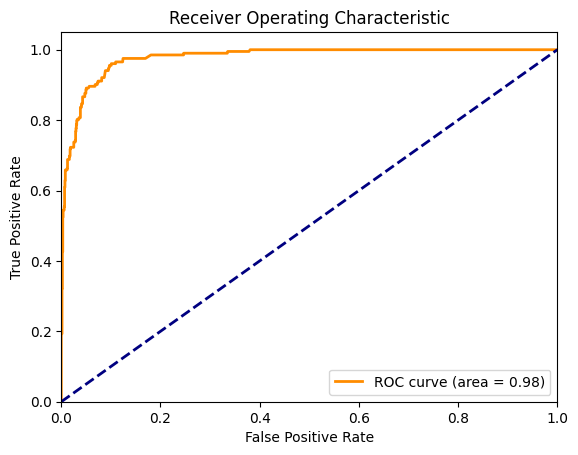

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()